In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from importlib import reload
import evaluations


/tmp/ipykernel_520/3698648062.py:20: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(im)


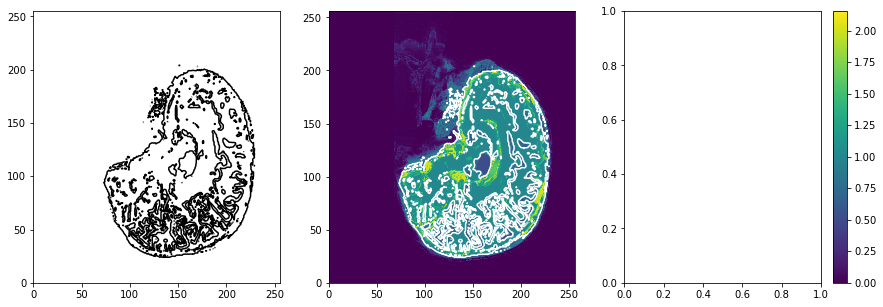

In [3]:

tissue_prob_map = loadmat('/home/anne/Masterarbeit/masterarbeit/2d//data/TPMSliceAnne.mat')

white_prob = tissue_prob_map['tpm']['white'][0][0]
gray_prob = tissue_prob_map['tpm']['gray'][0][0]
csf_prob = tissue_prob_map['tpm']['csf'][0][0]
skull_prob = tissue_prob_map['tpm']['skull'][0][0]
scalp_prob = tissue_prob_map['tpm']['scalp'][0][0]

head =  white_prob + gray_prob + csf_prob + skull_prob # + scalp_prob
inner =  white_prob + gray_prob + csf_prob
brain = white_prob + gray_prob

fig, axis = plt.subplots(1,3, figsize=(15,5))

axis[0].contour(head, levels=[0.95], colors=['black'])
#im = axis[0].pcolor(brain)
#fig.colorbar(im) 
axis[1].contour(head, levels=[0.95], colors=['white'])
im = axis[1].pcolor(head)
fig.colorbar(im) 

36
18
9
0.0


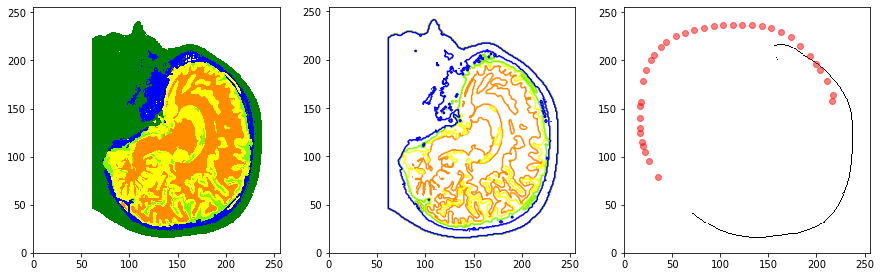

In [33]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig, axis = plt.subplots(1,3, figsize=(15,5))

x = np.linspace(0, 1, 256)
y = np.linspace(0, 1, 256)
z = np.ndarray((256,256))
g = np.ndarray((256,256))
s = np.ndarray((256,256))
boundary = np.zeros((256,256))

for i in range(256):
    for j in range(256):
        probs = [gray_prob[i,j],white_prob[i,j],csf_prob[i,j],skull_prob[i,j],scalp_prob[i,j]]
        if white_prob[i,j]>0.5: 
            z[i,j]=1
        elif (gray_prob[i,j] + white_prob[i,j])>0.5: 
            z[i,j]=2
        elif (csf_prob[i,j] + gray_prob[i,j] + white_prob[i,j])>0.5: 
            z[i,j]=3
        elif (skull_prob[i,j]+csf_prob[i,j] + gray_prob[i,j] + white_prob[i,j])>0.5: 
            z[i,j]=4
        elif (scalp_prob[i,j]+csf_prob[i,j]+skull_prob[i,j] + gray_prob[i,j] + white_prob[i,j])>0.5: 
            z[i,j]=5
        else:
            z[i,j]=0
b = []
for i in range(255):
    for j in range(255):
        if (z[i,j] == 5
        and (z[i-1,j] == 0 or z[i+1,j] == 0 or z[i,j-1] == 0 or z[i,j+1] == 0)
        and (j>155 or (j>70 and i<45))
        and (z[i-1,j] == 5 or z[i+1,j] == 5 or z[i,j-1] == 5 or z[i,j+1] == 5 or z[i-1,j-1] == 5 or z[i+1,j+1] == 5)):
            boundary[i,j] = 1
            b.append([i,j])

for i in range(255):
    for j in range(255):
        g[i,j] = i     
cmap = ListedColormap(["white", "darkorange", "yellow", "lawngreen", "blue", "green"])
set = axis[0].pcolor(z, cmap=cmap)
set = axis[1].contour(z, cmap=cmap, levels = [0,1,2,3,4,5])
set = axis[2].pcolor(boundary, cmap='Greys')
axis[0].set_aspect(1)
axis[1].set_aspect(1)
axis[2].set_aspect(1)

electrodes_1 = []
electrodes_2 = []
electrodes_3 = []

for k in range(0,len(b),10):
    electrodes_3.append(b[k])

for k in range(0,len(electrodes_3),2):
    electrodes_2.append(electrodes_3[k])

for k in range(0,len(electrodes_2),2):
    electrodes_1.append(electrodes_2[k])

print(len(electrodes_3))
print(len(electrodes_2))
print(len(electrodes_1))

np.savez_compressed("/home/anne/Masterarbeit/masterarbeit/2d/data/electrodes_3.npz", electrodes_3)
np.savez_compressed("/home/anne/Masterarbeit/masterarbeit/2d/data/electrodes_2.npz", electrodes_2)
np.savez_compressed("/home/anne/Masterarbeit/masterarbeit/2d/data/electrodes_1.npz", electrodes_1)

print(g[170,150])
#evaluations.draw_point(axis[1], [150,170], alpha=1)
#evaluations.draw_point(axis[1], [142,152], alpha=1)

electrodes = np.array(electrodes_3)
axis[2].scatter(electrodes[:,0], electrodes[:,1], c='red', alpha=0.5)

plt.show()


[ 6. 12.]
1.0
[12. 25.]
0.9966803777220797
[25. 50.]
0.9721811206165064
[ 50. 100.]
0.0


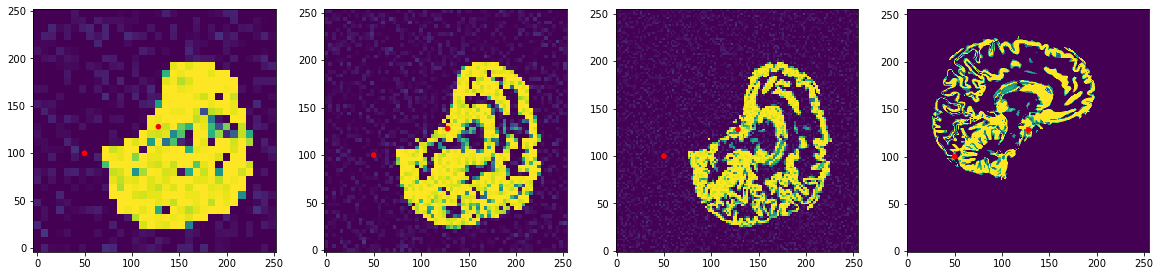

In [15]:
from os import name
import utility_functions
import evaluations

fig, axis = plt.subplots(1,4, figsize=(20,5))

paths = [
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_32.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_64.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_128.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_256.npz"]
numbers = [32,64,128,256]

point = [50,100]
start = [128,128]
for i in range(4):
    n = numbers[i]

    mesh = np.load(paths[i])

    elements = mesh['elements']
    nodes = mesh['nodes']
    labels = mesh['labels']
    gray_probs = mesh['gray_probs']
    
    x = np.zeros(n+1)
    y = np.zeros(n+1)
    z = np.ndarray((n,n),float)
    g = np.ndarray((n,n),float)

    x = nodes[:n,0]
    y = nodes[:n,0]

    for k in range(n):
        for j in range(n):
            z[k,j] = labels[j+n*k]
            g[k,j] = gray_probs[j+n*k]

    axis[i].pcolormesh(x,y,g)
    axis[i].set_aspect(1)
    evaluations.draw_point(axis[i], [start[1],start[0]], alpha=1)

    evaluations.draw_point(axis[i], [point[0],point[1]], alpha=1)

    c = utility_functions.find_next_center(mesh,'hex',point)
    print(c)
    print(g[int(c[0]),int(c[1])])
    
plt.show()


[16. 16.]
1.0
[32. 32.]
0.969029057606752
[65. 64.]
0.9865293941744195
[130. 128.]
1.0


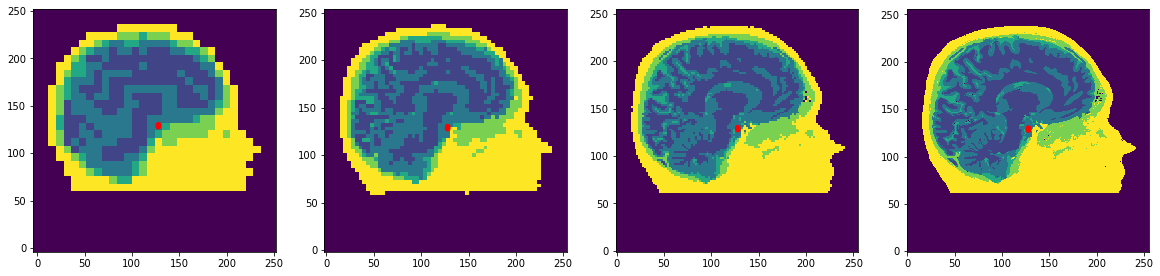

In [6]:
from os import name
import utility_functions
import evaluations

fig, axis = plt.subplots(1,4, figsize=(20,5))

paths = [
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_32.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_64.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_128.npz",
    "/home/anne/Masterarbeit/masterarbeit/2d/data/mesh_hex_256.npz"]
numbers = [32,64,128,256]

point = [130,128]
start = [128,128]
for i in range(4):
    n = numbers[i]

    mesh = np.load(paths[i])

    elements = mesh['elements']
    nodes = mesh['nodes']
    labels = mesh['labels']
    gray_probs = mesh['gray_probs']
    
    x = np.zeros(n+1)
    y = np.zeros(n+1)
    z = np.ndarray((n,n),float)
    g = np.ndarray((n,n),float)

    x = nodes[:n,0]
    y = nodes[:n,0]

    for k in range(n):
        for j in range(n):
            z[k,j] = labels[k+n*j]
            g[k,j] = gray_probs[k+n*j]

    axis[i].pcolormesh(x,y,z)
    axis[i].set_aspect(1)
    evaluations.draw_point(axis[i], [start[1],start[0]], alpha=1)

    evaluations.draw_point(axis[i], [point[1],point[0]], alpha=1)

    c = utility_functions.find_next_center(mesh,'hex',point)
    print(c)
    print(g[int(c[0]),int(c[1])])
    
plt.show()


In [7]:
import json
import eeg_model
import math

##### READ CONFIG #####
# Get path to config file
parameters_path = "/home/anne/Masterarbeit/masterarbeit/2d/configs/mlda_with_orientation.json"

# Read config file
file = open(parameters_path)
config = json.load(file)
file.close()

##### SET GENERAL CONFIGS #####
model = config["Setup"]["Matrix"]
relative_noise = config["ModelConfig"]["RelativeNoise"]
center = (config["Geometry"]["Center"]["x"], config["Geometry"]["Center"]["y"])
conductivities = config["Geometry"]["Conductivities"]
chains = config["Setup"]["Chains"]

# Set type
dipole_type = config["ModelConfig"]["Dipole"]["Type"]

##### SET DIPOLE #####
# Dipole position is either read from the config or generated randomly
s_ref = {}
for c in range(chains):
    print(c)
    if config["Setup"]["Dipole"] == "Random":
        mesh_ref = np.load(config["GeneralLevelConfig"]["Reference"]["Mesh"] if "Reference" in config["GeneralLevelConfig"]
                           else config[config["Sampling"]["Levels"][-1]]["Reference"]["Mesh"])
        while (True):
            position = (utility_functions.get_random(config["Geometry"]["Domain_x_Min"], config["Geometry"]["Domain_x_Max"]),
                        utility_functions.get_random(config["Geometry"]["Domain_y_Min"], config["Geometry"]["Domain_y_Max"]))
            center_ref = utility_functions.find_next_center(
                mesh_ref, 'hex', position)
            if (mesh_ref['gray_probs'][int(center_ref[0]+mesh_ref['cells_per_dim']*center_ref[1])] > 0.5):
                break
    else:
        position = (config["ModelConfig"]["Dipole"]["Position"]
                    ["x"], config["ModelConfig"]["Dipole"]["Position"]["y"])

    # Dipole orientation is either radial or given by the config or generated randomly
    if dipole_type == 'Radial':
        s_ref[c] = utility_functions.get_radial_dipole(position, center)
    else:
        if config["Setup"]["Dipole"] == "Random":
            rho = utility_functions.get_random(0, 2*math.pi)
        else:
            rho = config["ModelConfig"]["Dipole"]["Orientation"]["rho"]

        print("Dipole:")
        print(utility_functions.get_dipole(position, center, rho))
        s_ref[c] = utility_functions.get_dipole(position, center, rho)

    ##### COMPUTE REFERENCE SENSOR VALUES #####
    # Read configs yielding for all levels
    general_level_config = config["GeneralLevelConfig"]

    if "Reference" in general_level_config:
        b_ref_general = {}
        sigma_0_general = {}
        for c in range(chains):
            transfer_matrix = general_level_config["Reference"]["TransferMatrix"]
            mesh = general_level_config["Reference"]["Mesh"]
            source_model = general_level_config["Reference"]["SourceModel"]
            config_source = config[source_model]
            b_ref_general[c], sigma_0_general[c] = utility_functions.calc_disturbed_sensor_values(s_ref[c], transfer_matrix, mesh, conductivities, config_source, relative_noise)

    ##### SET LEVEL DEPENDENT CONFIGS #####
    # Initialize dictionairies
    path_electrodes = {}
    mesh_types = {}
    path_meshs = {}
    path_matrices = {}
    var_factor = {}
    b_ref = {}
    sigma = {}

    # Iterate through all levels
    levels = config["Sampling"]["Levels"]
    for level in levels:
        # Read config yielding for the current level
        level_config = config[level]

        # Set paths
        path_electrodes[level] = level_config["Electrodes"] if "Electrodes" in level_config else general_level_config["Electrodes"]
        path_meshs[level] = level_config["Mesh"] if "Mesh" in level_config else general_level_config["Mesh"]
        var_factor[level] = level_config["VarFactor"] if "VarFactor" in level_config else general_level_config["VarFactor"]
        mesh_types[level] = level_config["MeshType"] if "MeshType" in level_config else general_level_config["MeshType"]

        path_matrices[level] = level_config["TransferMatrix"] if "TransferMatrix" in level_config else general_level_config["TransferMatrix"]

        m = len(np.load(path_electrodes[level])["arr_0"])

        b_ref[level] = b_ref_general
        sigma[level] = sigma_0_general

    ##### CREATE EEG MODEL #####
    # Either transfer matrix or leadfield matrix is used in the model
    print(path_electrodes)
    
    if model == 'T':
        testmodel = eeg_model.EEGModelTransfer(config, levels, b_ref, sigma, path_matrices,
                                     mesh_types, path_meshs, conductivities, center, dipole_type)
    elif model == 'L':
        testmodel = eeg_model.EEGModelLeadfield(
            levels, b_ref, sigma, path_matrices, path_meshs)


KeyError: 'Dipole'

In [ ]:
import leadfield

chain = 0
level = "Level3_V"
theta = np.array([130,128,0])

print(testmodel.b_ref[level][chain])

next_dipole = utility_functions.get_dipole(theta[0:2], testmodel.center, theta[2])
b = testmodel.meg_drivers[level].applyEEGTransfer(testmodel.transfer_matrix[level],[next_dipole],testmodel.config[level])[0]
#print(b)

posterior = ((1/(2*testmodel.sigma[level][chain]**2))**(testmodel.m[level]/2))*np.exp(-(1/(2*testmodel.sigma[level][chain]**2))*(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2)/np.linalg.norm(np.array(testmodel.b_ref[level][chain]), 2))**2)
print(testmodel.sigma[level][chain])



print("___________________________________________________")
print("NORM")
print(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2))

print("POSTERIOR")
print(posterior)
print(np.log(posterior))
print(testmodel.posterior(theta, chain, level))

c = utility_functions.find_next_center(testmodel.mesh[level],testmodel.mesh_type[level],theta)
tissue_prob = testmodel.tissue_probs[level][int(c[0]+testmodel.mesh[level]['cells_per_dim']*c[1])]
print(tissue_prob)

print("___________________________________________________")
theta = np.array([122,122,-8])

next_dipole = utility_functions.get_dipole(theta[0:2], testmodel.center, theta[2])
b = testmodel.meg_drivers[level].applyEEGTransfer(testmodel.transfer_matrix[level],[next_dipole],testmodel.config[level])[0]
#print(b)

posterior = ((1/(2*testmodel.sigma[level][chain]**2))**(testmodel.m[level]/2))*np.exp(-(1/(2*testmodel.sigma[level][chain]**2))*(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2)/np.linalg.norm(np.array(testmodel.b_ref[level][chain]), 2))**2)
print("NORM")
print(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2))

print("POSTERIOR")
print(posterior)
print(np.log(posterior))
print(testmodel.posterior(theta, chain, level))

c = utility_functions.find_next_center(testmodel.mesh[level],testmodel.mesh_type[level],theta)
tissue_prob = testmodel.tissue_probs[level][int(c[0]+testmodel.mesh[level]['cells_per_dim']*c[1])]
print(tissue_prob)


NameError: name 'testmodel' is not defined

In [ ]:
chain = 0
theta = np.array([130,125,0])

print(testmodel.config)

level = "Level3_P"

#print(testmodel.b_ref[level][chain])

next_dipole = utility_functions.get_dipole(theta[0:2], testmodel.center, theta[2])
b = testmodel.meg_drivers[level].applyEEGTransfer(testmodel.transfer_matrix[level],[next_dipole],testmodel.config[level])[0]
print(b)

posterior = ((1/(2*testmodel.sigma[level][chain]**2))**(testmodel.m[level]/2))*np.exp(-(1/(2*testmodel.sigma[level][chain]**2))*(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2)/np.linalg.norm(np.array(testmodel.b_ref[level][chain]), 2))**2)
#print(testmodel.sigma[level][chain])

level = "Level3_V"

#print(testmodel.b_ref[level][chain])

next_dipole = utility_functions.get_dipole(theta[0:2], testmodel.center, theta[2])
b = testmodel.meg_drivers[level].applyEEGTransfer(testmodel.transfer_matrix[level],[next_dipole],testmodel.config[level])[0]
print(b)

posterior = ((1/(2*testmodel.sigma[level][chain]**2))**(testmodel.m[level]/2))*np.exp(-(1/(2*testmodel.sigma[level][chain]**2))*(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2)/np.linalg.norm(np.array(testmodel.b_ref[level][chain]), 2))**2)
#print(testmodel.sigma[level][chain])

chain = 0
theta = np.array([129,125,0])

print(testmodel.config)

level = "Level3_P"

#print(testmodel.b_ref[level][chain])

next_dipole = utility_functions.get_dipole(theta[0:2], testmodel.center, theta[2])
b = testmodel.meg_drivers[level].applyEEGTransfer(testmodel.transfer_matrix[level],[next_dipole],testmodel.config[level])[0]
print(b)

posterior = ((1/(2*testmodel.sigma[level][chain]**2))**(testmodel.m[level]/2))*np.exp(-(1/(2*testmodel.sigma[level][chain]**2))*(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2)/np.linalg.norm(np.array(testmodel.b_ref[level][chain]), 2))**2)
#print(testmodel.sigma[level][chain])

level = "Level3_V"

#print(testmodel.b_ref[level][chain])

next_dipole = utility_functions.get_dipole(theta[0:2], testmodel.center, theta[2])
b = testmodel.meg_drivers[level].applyEEGTransfer(testmodel.transfer_matrix[level],[next_dipole],testmodel.config[level])[0]
print(b)

posterior = ((1/(2*testmodel.sigma[level][chain]**2))**(testmodel.m[level]/2))*np.exp(-(1/(2*testmodel.sigma[level][chain]**2))*(np.linalg.norm(np.array(testmodel.b_ref[level][chain])-np.array(b), 2)/np.linalg.norm(np.array(testmodel.b_ref[level][chain]), 2))**2)
#print(testmodel.sigma[level][chain])


{'Level1_V': {'solver.reduction': 1e-10, 'source_model': {'type': 'venant', 'numberOfMoments': 2, 'referenceLength': 20, 'weightingExponent': 1, 'relaxationFactor': 1e-06, 'mixedMoments': True, 'restrict': True, 'initialization': 'closest_vertex'}, 'post_process': True, 'subtract_mean': True}, 'Level3_V': {'solver.reduction': 1e-10, 'source_model': {'type': 'venant', 'numberOfMoments': 2, 'referenceLength': 20, 'weightingExponent': 1, 'relaxationFactor': 1e-06, 'mixedMoments': True, 'restrict': True, 'initialization': 'closest_vertex'}, 'post_process': True, 'subtract_mean': True}}


KeyError: 'Level3_P'